# Distribution Preserving Multiple Hypotheses Prediction

This notebook contains the code and explanations for exemplary conditional probablity distributions presented in the paper "Uncertainty Modelling with Distribution Preserving Multiple Hypotheses Prediction" by T. Leemann, M. Sackmann, J. Thielecke und U. Hofmann.

The optimization of a single distribution from the paper is shown and the two simple application examples that learn a conditional distribution are implemented:  The callcenter example and the eye-diagram example (not shown in the paper).

This notebook contains five sections.
1. The general training functions and loss function for multiple hypotheses prediction are implemented
2. The example in the paper on a single 2D-distribution is implemented
3. The two application examples with conditional probabilities are presented and corresponding sampling functions are implemented
4. The networks are trained for both examples and the results are shown

In [3]:
# imports
import torch
import torch.distributions.exponential as torchexp
import matplotlib.pyplot as plt
import numpy as np
import math

## 1. Define the two loss functions and general utility functions
We start by defining the two versions of the WTA-loss that are discussed in the paper, $l_2$-WTA and $l_{dp}$-WTA.
They calculate the distance to the nearest hypothesis:
$$\mathcal{L}(x,y) = \min_{1...N}d(y_i(x), y)$$
for $d=l_2$ and $d=l_{dp}$.

Note that all functions shown are already vectorized. They take a matrix containing the $y_i$s and a vector of the same length with the ground truth $y$ as input.

In [4]:
# Define the loss functions
def nearest_log_loss_nd_delta(y, hyps, attraction_factor, delta = 1e-2):
    """ 
    Calculates WTA with the ldp-loss function for n points in dim dimensions using the logarithmic loss function with the
    additional delta as proposed by Krishna et al.
    y: The true observation(label) for a specific value of x. Tensor of Shape (batch_size, dim)
    hyps: The hypotheses returned by the net for the same specific value of x. Shape (batch_size, N, dim) (N: The number of hypotheses)
    attraction factor: factor by which the points are draw towards the samples (small double or 0), speeds up coarse convergence to the conditional mean (proposed by Rupprecht et al.)
    delta: Value added to the log to prevent numerical instabilities (default: 1e-2)
    """
    dims = y.shape[1]
    n = hyps.shape[1] # Number of points

    # compute nearest neighbors
    # compute distance vectors tensor
    distance_vect = hyps - y.reshape(-1, 1, dims)
    dists2 = torch.sum(torch.pow(distance_vect, 2.0), dim=2)  # shape [batch_size, n]
    dists_min = torch.sqrt(torch.min(dists2, dim=1)[0]+1e-8)  # Full WTA
    # calc losses
    # Logrithmic part
    dn_loss = torch.sum(torch.log(dists_min + delta))
    return dn_loss + attraction_factor*torch.sum(dists2.flatten())

def nearest_l2_loss_nd(y, hyps, attraction_factor, k=2):
    """ Same inputs as for nearest_log_loss_nd_delta,
    calculate the WTA with l2-Loss (for k=2), L1 loss (for k=1), (or l_k-loss min ||x-x_i||^k)"""
    dims = y.shape[1]
    distance_vect = hyps - y.reshape(-1, 1, dims)
    dists2 = torch.sum(distance_vect * distance_vect, dim=2) # shape [batch_size, n]
    dist_min = torch.min(dists2, dim=1)[0]
    dist_min = torch.pow(dist_min, (k/2))
    return torch.sum(dist_min) + attraction_factor*torch.sum(dists2.flatten())

For some of our examples, we will use Gaussian Mixture Models (GMM) as distributions. These are weighted sums of multiple normal distributions.
We therefore implement a vectorized sampling function and a density function:

In [5]:
# General function to draw from a conditional Gaussian Mixture Model
# In multiple dimensions, we support only GMMs where for each mixture component, the covariance matrix is diagonal.
def draw_multiple_gmm_samples(weights, means, covs):
    """ Draw M samples form a conditional D-dimensional GMM, where for each sample, location and scale parameters (std deviation) may vary. The weights remain fixed for all conditions in
        this implementation.
        Weights have size(N), where N is the number of components (same weights for all samples.)
        locations and scales have the size(M, N, D) or size(M, N), where M is the number of samples and the locations and scales of the
        N components are given for each dimension. Dimensions are assumend independent.
        Returns (M, D) tensor with the M samples.
    """
    n_samples = covs.shape[0]
    dims = 0
    if len(means.shape) == 2:
        # Legacy support for one dimensional mixtures
        dims = 1
        means = means.reshape((means.shape[0], means.shape[1], 1))
        covs = covs.reshape((covs.shape[0], covs.shape[1], 1))
    else:
        dims = means.shape[2]

    unifrand = torch.rand(n_samples)
    # Ends and begins of the intervals for each mixture component
    cumends = weights.cumsum(dim=0)
    cumbegins = torch.cat((torch.tensor([0], dtype=torch.float), cumends[:-1]))
    used_locs = torch.zeros(n_samples, dims)
    used_scales = torch.zeros(n_samples, dims)
    samples = torch.randn(n_samples, dims)
    # Loop over components
    for i in range(0, len(weights)):
        used_locs[(cumbegins[i] <= unifrand) & (cumends[i] > unifrand), :] = means[(cumbegins[i] <= unifrand) & (cumends[i] > unifrand), i, :]
        used_scales[(cumbegins[i] <= unifrand) & (cumends[i] > unifrand), :] = covs[(cumbegins[i] <= unifrand) & (cumends[i] > unifrand), i, :]

    return used_locs + samples*used_scales

Second, we need a function for density calculation:

In [6]:
from torch.distributions.multivariate_normal import MultivariateNormal 

# Calculate a single 1D PDF
def calc_single_gmm_pdf(weights, location, scale, x_val):
    """ Calculate the pdf values of a GMM in D dimension with weights, locations and scales (diagonal covariance matrices are required) at the x values given in x_val.
        weights: N-Tensor with sum(weights)=1
        location: N, D-Tensor (N-Tensor in 1D) with the locations of the mixtures
        scale: N, D-tensor (N-Tensor in 1D) with the standard deviation of the mixtures
        x_val: M, D-tensor (N-Tensor in 1D) with the values where pdf is evaluated
        returns M tensor with the pdf values.
    """
    n_comp = len(weights)
    if len(location.shape) == 1:
        # Legacy support for one dimensional mixtures
        dims = 1
        location = location.reshape((-1, 1))
        scale = scale.reshape((-1, 1))
        x_val = x_val.reshape((-1, 1))
    else:
        dims = location.shape[1]
    
    pdf_val = torch.zeros(x_val.shape[0])
    for i in range(n_comp):
        m = MultivariateNormal(location[i,:], torch.diag(scale[i,:]*scale[i,:]))
        pdf_val = pdf_val + weights[i]*torch.exp(m.log_prob(x_val))
    return pdf_val

Finally, we need a training function. Keep on reading until the examples to see how it is used. We just implement it already up here, so all the examples can be run on their own.

## 2. A single distribution example

We now implement the example plots from the paper on a single distribution, that has the form of a 2D-GMM.

Define the mixture components:

In [5]:
weights = torch.tensor([0.6,0.25,0.15])
stds = torch.tensor([[0.6,0.6], [0.3, 0.5], [0.25, 0.25]]) # standard deviations
means = torch.tensor([[-0.7,-0.2], [0, 1.2], [0.8, -0.1]])

First, we visualize the actual density.

In [6]:
def calculate_2d_gmm_density(x_val, y_val, weights, means, stds):
    """ Wrapper to calc_single_gmm_pdf where the density is evaluated on a grid on (x_val, y_val) for a single pdf. 
    Returns a (len(y_val), len(x_val))-sized matrix, that can be used with imshow
    """
    y_val = y_val.flip(dims=[0])  # Revert y values (because imshow has the y axis from top to btm)
    xd, yd = torch.meshgrid(x_val, y_val)
    pnt_rep = torch.stack((xd.flatten(), yd.flatten()), dim=1)
    res = calc_single_gmm_pdf(weights, means, stds, pnt_rep)
    return res.reshape(len(x_val), len(y_val)).t()

Text(0.5, 1.0, 'Color plot of the density')

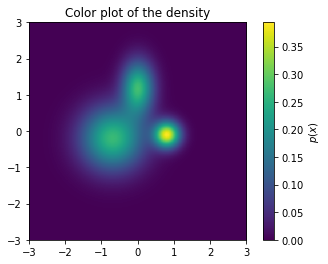

In [7]:
# Test plot for the density function
y_val = torch.linspace(-3, 3, 600)
x_val = torch.linspace(-3, 3, 600)
dens = calculate_2d_gmm_density(x_val, y_val, weights, means, stds)
ims1 = plt.imshow(dens.data, interpolation='none', extent=[min(x_val), max(x_val), min(y_val), max(y_val)])
plt.colorbar(label=r"$p(x)$")
plt.title("Color plot of the density")

In [8]:
# A sampling function for the optimizer
def sample_gmm(n_samples: int):
    return draw_multiple_gmm_samples(weights, means.unsqueeze(0).repeat(n_samples,1,1), stds.unsqueeze(0).repeat(n_samples,1,1))

In [9]:
use_file = True # Set to true to load already optimal hypotheses from file and skip the optimization part.
n_hyp = 150 # Set number of hypotheses here (if use_file = True, the number of hypotheses from the file are used.)

In [10]:
if use_file:  
    pts_ldp = torch.load("data/150PtsUnbiased.pt").requires_grad_(True)
    pts_l2 = torch.load("data/150PtsL2.pt").requires_grad_(True)
else:
    # In theory, you could start with any points (as we will see with later examples) when they are already approximately in place.
    pts_ldp = sample_gmm(n_hyp).requires_grad_(True)
    pts_l2 = sample_gmm(n_hyp).requires_grad_(True)

We will now optimize the hypotheses for the different loss function. You safely skip the following cells by loading the points from the file `data/150PtsUnbiased.pt` and `data/150PtsL2.pt`

In [11]:
# Optimize points for a nd normal distribution
def optimize_nd_single_distribution(pts: torch.tensor, sample_func, optim: torch.optim.Optimizer,
                                     n_samples: float, loss_func, steps: int, attraction_factor: float = 0.0):
    """
    Optimize the WTA Loss for a single (non-conditional) distribution in D dimensions.
    We use N hypotheses and M samples per optimization step.
    Parameters: pts: size(N, D) tensor, contains the location of the points, that will be optimized.
                sample_func: function(M: int) function that returns a (M, D) tensor with M samples from the distribution
                optim: A torch optimizer to be used
                n_samples: The number of samples M to be sampled in each optimization step
                loss_func: A loss function with the signature of unbiased_mhp_loss_nd, nearest_l2_loss_nd, ...
                steps: Number of optimization steps to do until this function returns
                attraction_factor: float that defines how much all points are moved towards the samples
    """
    dims = pts.shape[1]
    for i in range(0, steps):
        samples = sample_func(n_samples).requires_grad_(False)
        pts_for_samples = pts.unsqueeze(0).repeat(n_samples, 1, 1)

        loss_val = loss_func(samples, pts_for_samples, attraction_factor)
        loss_val.backward()
        optim.step()
        optim.zero_grad()

    print("Loss after " + str(steps) + " steps: " + str(loss_val.item()))
    smean = pts.mean(dim=0)
    cov = (1./(pts.shape[0]))*(pts-smean).t().matmul(pts-smean)
    print("Covariance: \n" + str(cov.data))
    return pts

In [12]:
num_runs = 20
samples_per_iter = 2000

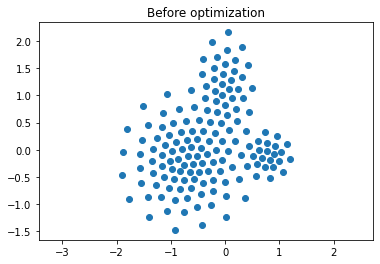

Loss after 200 steps: -4771.9111328125
Covariance: 
tensor([[0.5154, 0.1206],
        [0.1206, 0.5982]])
Loss after 200 steps: -4766.39892578125
Covariance: 
tensor([[0.5146, 0.1212],
        [0.1212, 0.6000]])
Loss after 200 steps: -4859.806640625
Covariance: 
tensor([[0.5138, 0.1209],
        [0.1209, 0.5990]])
Loss after 200 steps: -4794.18408203125
Covariance: 
tensor([[0.5134, 0.1214],
        [0.1214, 0.5990]])
Loss after 200 steps: -4823.9111328125
Covariance: 
tensor([[0.5139, 0.1206],
        [0.1206, 0.5984]])
Loss after 200 steps: -4818.10546875
Covariance: 
tensor([[0.5142, 0.1208],
        [0.1208, 0.5988]])
Loss after 200 steps: -4790.21484375
Covariance: 
tensor([[0.5152, 0.1208],
        [0.1208, 0.5982]])
Loss after 200 steps: -4793.63525390625
Covariance: 
tensor([[0.5154, 0.1199],
        [0.1199, 0.5991]])
Loss after 200 steps: -4803.34619140625
Covariance: 
tensor([[0.5152, 0.1207],
        [0.1207, 0.6001]])
Loss after 200 steps: -4776.5107421875
Covariance: 
tens

In [21]:
# Repeatly execute this cell, until you are satisfied with the results.
plt.scatter(pts_ldp[:, 0].data, pts_ldp[:, 1].data)
plt.title("Before optimization")
plt.gca().axis("equal")
plt.show()

optim_adam = torch.optim.Adam([pts_ldp], lr=5e-4)
for i in range(0, num_runs):
    pts_ldp = optimize_nd_single_distribution(pts_ldp, sample_gmm, optim_adam, samples_per_iter, nearest_log_loss_nd_delta, 200, 0.0)

# Save as you like
#torch.save(pts.detach(), "data/150PtsL2.pt")

Plot the resulting hypotheses after the optimization.

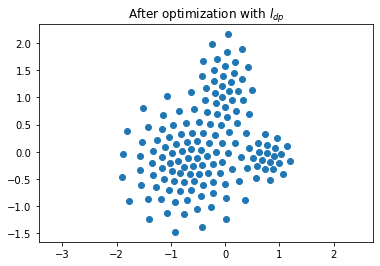

In [120]:
plt.title(r"After optimization with $l_{dp}$")
plt.scatter(pts_ldp[:, 0].data, pts_ldp[:, 1].data)
plt.gca().axis("equal")
plt.show()

In [87]:
# Repeatedly execute this cell, until you are satisfied with the results.
optim_adam = torch.optim.Adam([pts_l2], lr=5e-4)
for i in range(0, num_runs):
    pts_l2 = optimize_nd_single_distribution(pts_l2, sample_gmm, optim_adam, samples_per_iter, nearest_l2_loss_nd, 200, 0.0)

# Save as you like
#torch.save(pts.detach(), "data/150PtsL2.pt")

Loss after 200 steps: 23.308170318603516
Covariance: 
tensor([[0.7091, 0.1171],
        [0.1171, 0.7970]])
Loss after 200 steps: 22.219749450683594
Covariance: 
tensor([[0.7125, 0.1189],
        [0.1189, 0.8072]])
Loss after 200 steps: 21.3842830657959
Covariance: 
tensor([[0.7167, 0.1214],
        [0.1214, 0.8146]])
Loss after 200 steps: 22.427715301513672
Covariance: 
tensor([[0.7194, 0.1239],
        [0.1239, 0.8232]])
Loss after 200 steps: 22.046430587768555
Covariance: 
tensor([[0.7220, 0.1253],
        [0.1253, 0.8304]])
Loss after 200 steps: 23.46428871154785
Covariance: 
tensor([[0.7225, 0.1264],
        [0.1264, 0.8359]])
Loss after 200 steps: 23.21033477783203
Covariance: 
tensor([[0.7232, 0.1276],
        [0.1276, 0.8411]])
Loss after 200 steps: 21.991098403930664
Covariance: 
tensor([[0.7225, 0.1291],
        [0.1291, 0.8471]])
Loss after 200 steps: 22.048377990722656
Covariance: 
tensor([[0.7236, 0.1312],
        [0.1312, 0.8512]])
Loss after 200 steps: 22.814960479736328


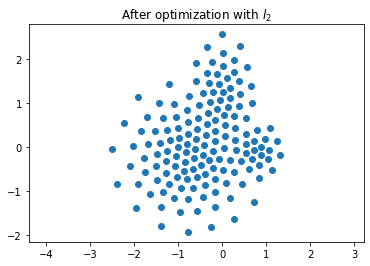

In [27]:
plt.title(r"After optimization with $l_{2}$")
plt.scatter(pts_l2[:, 0].data, pts_l2[:, 1].data)
plt.gca().axis("equal")
plt.show()

Visulize the difference in both hypotheses sets after training:

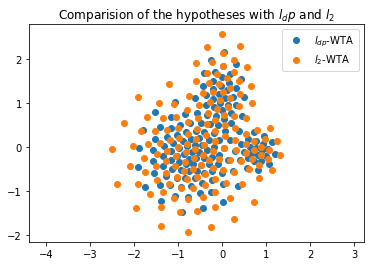

In [13]:
# Overlay of both distributions
plt.title(r"Comparision of the hypotheses with $l_dp$ and $l_2$")
plt.scatter(pts_ldp[:, 0].data, pts_ldp[:, 1].data, label=r"$l_{dp}$-WTA")
plt.scatter(pts_l2[:, 0].data, pts_l2[:, 1].data, label=r"$l_{2}$-WTA")
plt.legend()
plt.gca().axis("equal")
plt.show()

It becomes evident that the $l_2$-WTA spreads the hypotheses further out. We will now calculate the shares of data in each of the voronoi cells 

For the visualization, we also compare to some random points from the distribution.

In [14]:
# Visualize the three hypotheses distributions.
pts_rnd = sample_gmm(len(pts_l2))

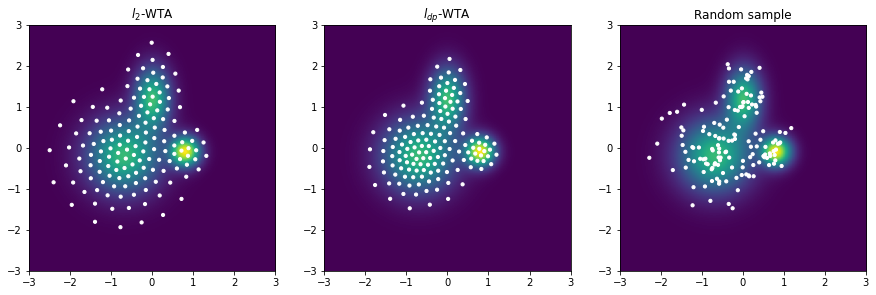

In [15]:
fig, axes = plt.subplots(1, 3)
points = [pts_l2, pts_ldp, pts_rnd]
titles = [r"$l_{2}$-WTA", r"$l_{dp}$-WTA", r"Random sample"]
for (ax, pts, title) in zip(axes, points, titles):
    ims1 = ax.imshow(dens.data, interpolation='none', extent=[min(x_val), max(x_val), min(y_val), max(y_val)])
    ax.scatter(pts[:, 0].data, pts[:, 1].data, 10*np.ones(len(pts)), c="w")
    ax.set_title(title)
fig.set_size_inches(15,15)


We finalize this example by calculating the shares of the distribution for each point and the corresponding voronoi regions.

In [16]:
# A brute force approach to calculating voronoi regions.
def calculate_2d_voronoi_regions(x_val, y_val, pts):
    """ return a matrix with the voronoi boundaries filled as ones, the remainder as zeros.
    x_val: vector with the values of the x-axis
    y_val: vector with the values of the y-axis
    pts: (N,2)-tensor, with the hypotheses
    return: a matrix (len(y_val), len(x_val))-shaped that can be used with imshow.
    Algorithm: Brute force. The nearest neighbors for all pixel boundary points (corners of the pixel) are computed.
    If all four pixel boundaries have the same neighbor, the pixel is not on the voronoi boundary (thus 0).
    If the nearest neighbor changes inside the pixel (e.g. the corners have different nearest neighbors, the value is 1.
    """
    dx = x_val[1]-x_val[0]
    dy = y_val[1]-y_val[0]
    x_valplus = torch.cat((x_val - 0.5 * dx, torch.tensor([x_val[-1]+0.5*dx])), dim=0)
    y_valplus = torch.cat((y_val - 0.5 * dy, torch.tensor([y_val[-1] + 0.5 * dy])), dim=0)
    y_valplus=y_valplus.flip(dims=[0])
    # Add one side pixel
    xd, yd = torch.meshgrid(x_valplus, y_valplus)
    pnt_rep = torch.stack((xd.flatten(), yd.flatten()), dim=1)
    pts_for_samples = torch.reshape(pts, (1, -1, 2)).repeat(pnt_rep.shape[0], 1, 1)
    distance_vect = pts_for_samples - pnt_rep.reshape(-1, 1, 2)
    dists2 = torch.sum(torch.pow(distance_vect, 2.0), dim=2)  # shape [batch_size, n]
    nearestpt = torch.min(dists2, dim=1)[1]  # Full WTA
    nearestpt = nearestpt.reshape(len(x_valplus), len(y_valplus))
    non_voi = nearestpt[:-1, :-1].eq(nearestpt[:-1, 1:]) & nearestpt[1:, :-1].eq(nearestpt[1:, 1:]) & nearestpt[1:, :-1].eq(nearestpt[:-1, 1:])

    # calculate distance gap between first and second neighbor
    #distgap = torch.sqrt(dists_min[:, 1]) - torch.sqrt(dists_min[:, 0])
    img = torch.zeros(len(x_val), len(y_val))
    img[~non_voi] = 1
    return img.t()

Furthermore, we define a function, that calculates the share for each hypothesis. Note that this function is also already vectorized and can be used with different hypotheses for each sample. This will be used in the later examples.

In [17]:
def get_shares_of_points(x, pnts):
    """ Get the shares of probability mass of each of the n Points
        x: The samples  [batch_size, dim]
        pnts: The values of the hypotheses for a specific sample. Shape [batch_size, n, dim]
        returns n-array with shares, sum(shares)=1.0
    """
    dims = x.shape[1]
    distance_vect = pnts - x.reshape(-1, 1, dims)
    dists2 = torch.sum(distance_vect * distance_vect, dim=2)  # shape [batch_size, n]
    _, ind = torch.min(dists2, dim=1)
    shares = torch.zeros(pnts.shape[1])
    uniques, cnts = torch.unique(ind, sorted=False, return_counts=True)
    shares[uniques] = cnts.float()
    return shares/pnts.shape[0]


Now, we will reproduce the plot from the paper.
First we define necessary parameters, and calculate the voronoi regions of the hypotheses.

In [18]:
# Parameters for the plot
y_val = torch.linspace(-2, 2.8, 250)
x_val = torch.linspace(-2.6, 1.6, 250)
dens = calculate_2d_gmm_density(x_val, y_val, weights, means, stds)

# Parameters for voronoi cell calculation
n_points_per_dim = 750 # The the resulution for the voronoi bounds
y_val_v = torch.linspace(-2, 2.8, n_points_per_dim)
x_val_v = torch.linspace(-2.6, 1.6, n_points_per_dim)

points = [pts_l2, pts_ldp, pts_rnd]

import matplotlib.pylab as pl
from matplotlib.colors import ListedColormap
# Create transparent colormap (hack from stackoverflow)
cmap = pl.cm.Greys
my_cmap = cmap(np.arange(cmap.N))
my_cmap[:,-1] = np.flip(np.linspace(0, 1, cmap.N))
transparent_cmap = ListedColormap(my_cmap)

In [19]:
myshares = [] # corresponding shares
myvoronoi = [] # Corresponding voronoi regions
# Calculate the expected loss and the voronoi regions (may take some time up to 30s)

n_eval_samples = 500000
for pts in points:
    samples = sample_gmm(n_eval_samples).requires_grad_(False)
    pts_for_samples = torch.reshape(pts, (1, -1, 2)).repeat(n_eval_samples, 1, 1)
    myshares.append(get_shares_of_points(samples, pts_for_samples))
    myvoronoi.append(calculate_2d_voronoi_regions(x_val_v, y_val_v, pts))

Finally, we are ready to do the final plot and bring it all together.

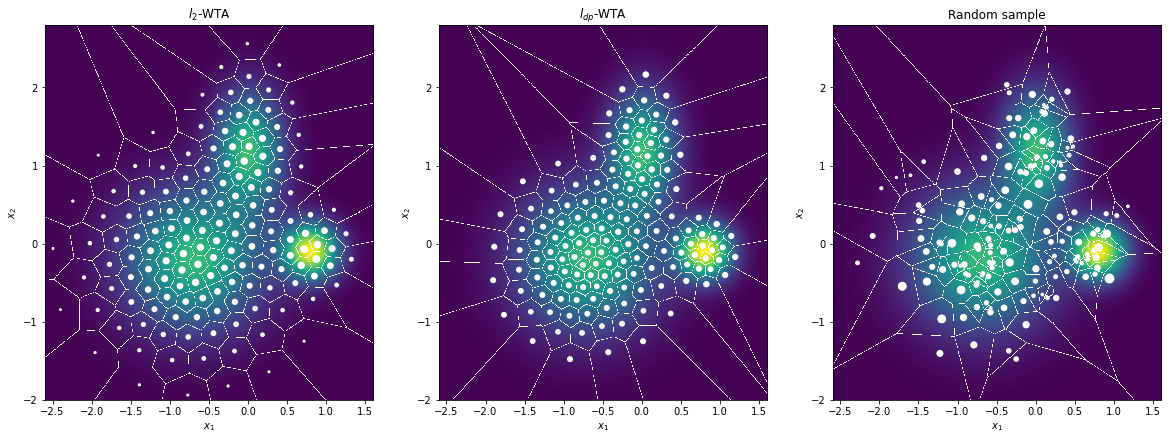

In [20]:
fig, axes = plt.subplots(1, 3)
titles = [r"$l_{2}$-WTA", r"$l_{dp}$-WTA", r"Random sample"]
for (ax, pts, title, shares, voronoi) in zip(axes, points, titles, myshares, myvoronoi):
    ims1 = ax.imshow(dens.data, interpolation='none', extent=[min(x_val), max(x_val), min(y_val), max(y_val)])
    ax.scatter(pts[:, 0].data, pts[:, 1].data, 25*pts.shape[0]*shares.data, c="w")
    ims2 = ax.imshow(1-voronoi.data, interpolation='none', extent=[min(x_val), max(x_val), min(y_val), max(y_val)], cmap=transparent_cmap)
    fig = plt.gcf()
    ax.set_xlabel(r"$x_1$")
    ax.set_ylabel(r"$x_2$")
    ax.set_title(title)
fig.set_size_inches(20,15)

As described in the paper, for the $l_2$-WTA, the shares differ by maginitudes and the method is not distribution perserving. The $l_{dp}$-WTA better preserves the underlying distributions characteristics. 

For the random sample, the characteristics are preserved, but the voronoi regions are not regular.

## 3. Define models and training functions for conditional distribution

We are now ready to apply the method to conditional distributions, using a neural network that maps from the condition $\mathbf{x}$ the the hypotheses $\mathbf{y}_i$.
In this part, we will define the neural network and the training functions that will be used.

First: define a simple, feed-forward neural network model with num_hypotheses outputs and a single input. For continuity and differentiability, we use the `torch.celu` actvation function.

In [7]:
from torch import nn, optim

# Simple MHP Model for a single dimensional output, that uses num_hypotheses and a single dimensional condition y.
# The model has four layes and neur_hidden neurons in two hidden layers. In this example we are using a CELU activation function.

class MHPModel1D(nn.Module):
    # Define a network with some layers
    def __init__(self, neur_hidden, num_hypotheses):
        self.neur_hidden = neur_hidden
        self.num_hypotheses = num_hypotheses
        super(MHPModel1D, self).__init__()

        # Define the layers here
        self.fc1 = nn.Linear(1, neur_hidden)
        self.fc2 = nn.Linear(neur_hidden, neur_hidden)
        self.fc3 = nn.Linear(neur_hidden, num_hypotheses)

    def forward(self, y):
        p = torch.celu(self.fc1(y))
        p = torch.celu(self.fc2(p))
        p = self.fc3(p)
        return p

A standard training procedure for the model:

In [8]:
def train_mhp_model(model, optimizer, sample_func, loss_func, num_iter, batch_size, attraction_factor):
    """ Train the multiple hypotheses model for a certain number of iterations. 
        model: The neural network model, instance of nn.Module
        optimizer: a torch.optimizer used for training
        sample_func: a function taking a size as an input and returning a tuple of (condition, samples) of that size
        num_iter: number of training steps to perform
        batch_size: Number of datapoints drawn from the distribution and used to compute gradients in each iteration
        attraction_factor: Attraction factor as proposed by Rupprecht et al. to speed up convergence
        loss_func: the loss_function used for training. 
    """
    for i in range(num_iter):
        model = model.train()
        # get the inputs
        y, x = sample_func(batch_size)
        # zero the parameter gradients
        optimizer.zero_grad()
        pnts = model(y.reshape(-1, 1))
        
        loss = loss_func(x.reshape(-1,1), pnts.reshape(pnts.shape[0], pnts.shape[1], 1), attraction_factor)
        loss.backward()
        optimizer.step()
        
    return model

In [9]:
# Define a plot function to visualize the hypotheses during the training progress
def plot_hypotheses(model, condition):
    model.eval()
    pts = model(condition.reshape(-1, 1))
    pts = pts.detach().numpy()
    plt.clf()
    for i in range(0, model.num_hypotheses):
        plt.plot(condition.detach().numpy(), pts[:, i],  '-b')
    plt.show()

To make sure the hypotheses are well appart and do not cross each other at the start of the training, we perform a short pretraining alignment step.
The hypotheses are seperated at the beginning.
Note that this step is not truly needed, hypotheses crossing may occur more often without this but will only result in a less structured optical impression.

In [10]:
def pre_train_mhp_model(model: MHPModel1D):
    """ Train the multiple hypotheses model so that the lines are spaced well apart.
    """
    num_iter = 500
    nh = model.num_hypotheses
    y = torch.linspace(-1,1,100)
    loss = nn.MSELoss()
    target = torch.linspace(-1, 1, nh).reshape(1, -1).repeat(len(y),1)
    model = model.train()
    for i in range(num_iter):
        optimizer.zero_grad()
        pts = model(y.reshape(-1,1))
        loss_val = loss(pts, target)
        loss_val.backward()
        optimizer.step()

## 4. Two application examples of Distribution Preserving Multiple Hypotheses Prediction

### 4.1. The callcenter example

This examples models a call center, with an arrival rate of call that varies over the day. It reaches its peaks at 8am and 4pm while we assume that the call center is opened from 6am until 8pm.
Arriving calls are modelled by an exponential distribution. An employee askes every fifth caller if is was satisfied with the service. In this example we model the time this has until five new calls arrive. 

In [11]:
def arrival_rate(hour):
    """ Return the number of arriving calls per minute, the arrival rate lambda of an exponential distribution. """
    return 2*torch.cos((hour-8)*math.pi/4)+5

Plot of the arrival rate depending on the hours of the day (0 = midnight, 12=noon, 24=midnight)

Text(0, 0.5, 'arrival rate (calls/min)')

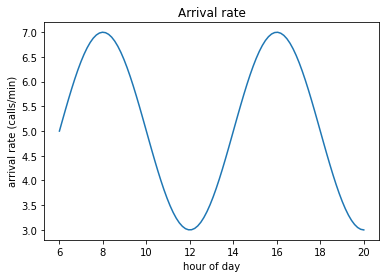

In [12]:
y_vals = torch.linspace(6, 20, 100) # Open 6h to 20h
x_vals = arrival_rate(y_vals)
plt.plot(y_vals, x_vals)
plt.title("Arrival rate")
plt.xlabel("hour of day")
plt.ylabel("arrival rate (calls/min)")

The time until 5 calls arrive can be modelled by an Erlang-distribution $Erlang(\lambda, 5)$.
The task is to model
* condition: $h$ hour of day (Range [6,20])
* target: $w$ waiting time that passes until 5 new calls arrive

The precise model with the rate function $\lambda(h)$ is 
$$p(w|h) = Erlang(\lambda(h), 5)$$
    

In [13]:
# General function to draw from an Erlang-Distribution which features a conditional arrival rate.
def draw_multiple_erlang_samples(rate: torch.Tensor, n: int = 5) -> torch.Tensor:
    """ Draw M samples form a conditional 1D Erlang distribution, where for each sample the rate lambda varies. The number n remains fixed.
        rate: M-Tensor with the different rates lambda.
        Returns (M) tensor with the M samples.
    """
    n_samples = rate.shape[0]
    rand_n = torch.rand(n_samples, n)
    return (-1/rate) * torch.sum(torch.log(rand_n+1e-8), dim = 1)

# define sampling function and draw samples
def draw_samples_callcenter(num_samples, enlarge_range = True):
    """ Draw num_samples samples for the callcenter example. 
        Return a tuple of  Returns a tuple of 
            (conditions: A num_samples-Tensor with the condition values (hours 5-21 if enlarge_range, else 6-20),
            values: A num_samples-Tensor with the observed waiting time values)
    """
    if enlarge_range:
        condition = torch.rand(num_samples)*16+5
    else:
        condition = torch.rand(num_samples)*14+6
    my_rates= arrival_rate(condition)
    samples = draw_multiple_erlang_samples(my_rates)
    return condition, samples

def draw_samples_callcenter_normalized(num_samples, enlarge_range = True):
    """ Draw num_samples samples for the callcenter example, that are approximately normalized, with unconditional mean approxmately 0, and unconditional variance approxmately 1.
        Return a tuple of  Returns a tuple of (conditions: A num_samples-Tensor, values: A num_samples-Tensor with the observed values)
    """
    cond, samp = draw_samples_callcenter(num_samples, enlarge_range)
    return (cond-13)/7, (samp-1)/0.6

In [14]:
# Functions to plot the distribution
def calc_single_erlang_pdf(rate, n, x_val):
    """ Calculate the pdf values of an erlang distribution in 1D at the values given in x_val.
    """
    pdf_vals = (math.pow(rate,n)*torch.pow(x_vals, n-1))*torch.exp(-rate*x_vals)/math.factorial(n-1)
    return pdf_vals


def colorplot_densities_erlang(targ, cond, rate_fun, n = 5):
    """
        color plot of the conditional erlang distribution dependent on y.
        targ: Target values (N-Tensor)
        cond: Condition value (M-Tensor)
        rate_fun: Function handle that returns a mapping from time to a rate lambda (Function lambda(h) in the formula)
        n: Parameter n of the Erlang distribution
    """
    densities = torch.zeros([len(targ), len(cond)])
    for i in range(0, len(cond)):
        y = torch.tensor([cond[i]])
        rate = rate_fun(y)
        densities[:, i] = calc_single_erlang_pdf(rate.item(), n, targ)
    plt.figure()
    plt.imshow(torch.flip(densities, dims = [0]).numpy(), interpolation='none', extent=[min(cond), max(cond), min(targ), max(targ)], aspect=2)

Test the drawing of samples and the plotting of the density as before.

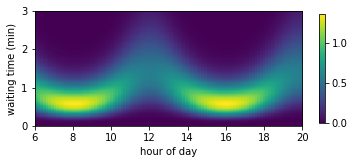

In [15]:
y_vals = torch.linspace(6, 20, 100)
x_vals = torch.linspace(0, 3, 100)
colorplot_densities_erlang(x_vals, y_vals, arrival_rate)
plt.xlabel("hour of day")
plt.ylabel("waiting time (min)")
plt.colorbar(shrink=0.5)

tensor(0.1591) tensor(0.9940)


Text(0, 0.5, 'waiting time (min)')

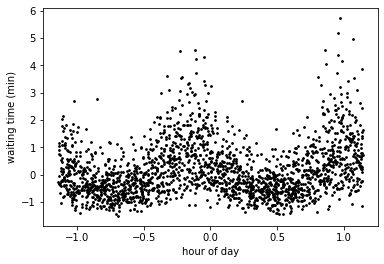

In [16]:
# Sampling functions from the model
num_samples = 2000
cond, samples = draw_samples_callcenter_normalized(num_samples)
print(samples.mean(), samples.std())
plt.scatter(cond, samples, 3, c="k")
plt.xlabel("hour of day")
plt.ylabel("waiting time (min)")

### 4.2. The eye-diagram example

A communication system is to transmit a series of 0s and 1s, while maintaining a time-continous amplitude.
As the level cannot "jump" from 0 to 1 (or vise versa) and this is furthermore not needed, the signal smoothly connects the values required at the time points (in this example we consider three time points t=-1, t=0, t=1) and 8 possible signals (000 ... 111). 
There are two models of the connecting function, one by sine/cosine functions and one by polynomials of degree 2.

In [17]:
time_vals = torch.linspace(-1, 1, 100)

In [18]:
def get_signal_sine(sig_id: int, time_vals: torch.Tensor) -> torch.Tensor:
    """ Return the value of the time continues signal at the values time_vals, that describes the signal sig_id.
    This implementation uses trigonometric functions to model the signals.
    Parameters:
        sig_id: int with values between 0...7, the signal to transmit, e.g. 5 = 101. Instead of the value 0, -1 is used in this implementation
        time_vals: the time values to evaluate the given signal at. Usual range is [-1, 1]
    """
    bit1 = 1 if sig_id & 0b001 else 0
    bit2 = 1 if sig_id & 0b010 else 0
    bit3 = 1 if sig_id & 0b100 else 0
    invert = False
    if bit1+bit2+bit3 > 1:
        invert = True
        sig_id = 7-sig_id
    ret_sig = torch.zeros_like(time_vals)
    if sig_id == 1:
        ret_sig = (torch.cos(((1-time_vals)/1.5)*math.pi)+0.5)/1.5
    if sig_id == 2:
        ret_sig = 0.5+0.5*torch.cos(time_vals*math.pi)
    if sig_id == 4:
        ret_sig = (torch.cos(((1+time_vals)/1.5)*math.pi)+0.5)/1.5
        
    if invert:
        ret_sig = 1.0 - ret_sig
    return 2*ret_sig -1

Plot the outcome again.

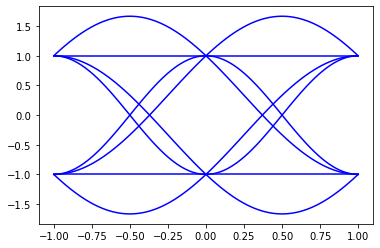

In [19]:
for i in range(8):
    plt.plot(time_vals, get_signal_sine(i, time_vals), "b")

We are now assuming that the signal $s_i(t)$ is not entirely precise but there is gaussian noise with a fixed variance $\sigma^2$ around each possible signal.
The goal of this example is to model the probablilty distribution of the signal amplitude value given the time in range t= [-1, 1].

* condition = time $t$ (range [-1, 1])
* value = signal amplitude $x$

The precise model is
$$p(x|t) = \sum_{i=0}^{7} \frac{1}{8}\mathcal{N}(s_i(t), \sigma^2)$$
The probaliblity distribution is a Gaussian mixture model for which sampling functions are implemented in the next step.

Define the actual probablity distribution and draw samples from it.

In [20]:
# Set the std_deviation of the uncertainty and the weights of the components here.
# Default is equal weight for each possible signal
single_std = 0.1
weights = torch.ones(8)/8

def loc_fun_eye(cond_vals):
    """ Return the means and the std-deviations for each component given the condition values in cond_vals.
        This function defines the mapping from condition to the corresponding mixture parameters.
        cond_vals: N-tensor
        Returns ((N,8)-tensor with the means of each component, (N,8)-tensor with the variances)
    """
    global single_std
    means = torch.cat([get_signal_sine(i, cond_vals).reshape(1,-1) for i in range(8)]).t()
    return means, torch.ones_like(means)*single_std, 


# Define a sampling function
def draw_samples_eye_diagram(num_samples, enlarge_range = True):
    """ Returns num_samples data points from the eye diagram model. Conditions in range [-1.2, + 1.2] to make sure the distribution continues at the edges or in range [-1,1] when enlarge_range==False.
        Returns a tuple of (conditions: A num_samples-Tensor with the condition values, values: A num_samples-Tensor with the observed values)
    """
    global weights, single_std
    if enlarge_range:
        conditions = 2.4*torch.rand(num_samples)-1.2
    else:
        conditions = 2*torch.rand(num_samples)-1
    my_means, my_stds = loc_fun_eye(conditions)
    samples = draw_multiple_gmm_samples(weights, my_means, my_stds)
    return conditions, samples


Text(0.5, 0, 'time')

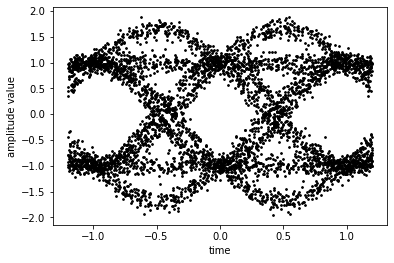

In [21]:
# Test the sampling
num_samples = 5000
y_vals, samples = draw_samples_eye_diagram(num_samples)
plt.scatter(y_vals, samples, 3, c="k")
plt.ylabel("amplitude value")
plt.xlabel("time")

Additionally for the graphics, the analytical probability density is computed and shown in a color plot.

In [22]:
def colorplot_densities(observation, cond, weights, location_fun):
    """
    color plot of the GMM mixture dependent on x_val (condition).
    observation: Values of the target value (observation, y_val)
    cond: Values of the condition (x_val)
    location_fun: Function handle that returns a mapping from a condition to gmm-parameters: returns locations (N-Tensor), scales = std-deviations (N-Tensor)
    """
    densities = torch.zeros([len(observation), len(cond)])
    for i in range(0, len(cond)):
        y = torch.tensor([cond[i]])
        locations, scales = location_fun(y)
        densities[:, i] = calc_single_gmm_pdf(weights, locations[0], scales[0], observation)
    plt.figure()
    plt.imshow(torch.flip(densities, dims = [0]).numpy(), interpolation='none', extent=[min(cond), max(cond), min(observation), max(observation)], aspect = 1/3)

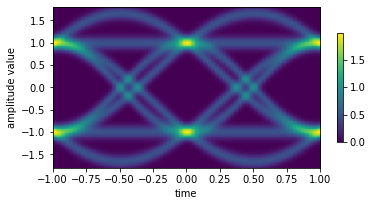

In [23]:
# Plot the distribution
x_vals = torch.linspace(-1.8, 1.8, 200)
y_vals = torch.linspace(-1, 1, 200)
colorplot_densities(x_vals, y_vals, weights, loc_fun_eye)
plt.ylabel("amplitude value")
plt.xlabel("time")
plt.colorbar(shrink = 0.5)

## 5. Train the model on the datasets

### 5.1. The callcenter dataset

In [87]:
# We provide pretrained models for num_hypotheses = 8, 15, 40
num_hypotheses=8

In [88]:
my_model = MHPModel1D(neur_hidden=80, num_hypotheses=num_hypotheses)

In [89]:
optimizer = optim.Adam(my_model.parameters(), lr=1e-3)

Remark: You can skip the next cells and load a pretrained model or train one yourself. Stored models for the call center feature neur_hidden=80, num_hypotheses=[8, 15, 40].

In [90]:
pre_train_mhp_model(my_model)

The hypotheses are aligned after the pretraining iterations.

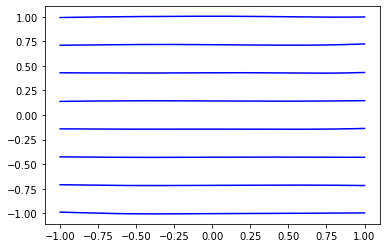

In [91]:
plot_hypotheses(my_model, torch.linspace(-1,1, 200)) 

Start out with the l2-loss (order is not important)

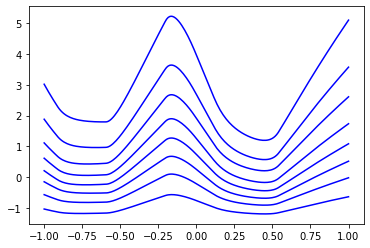

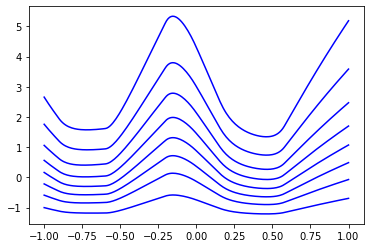

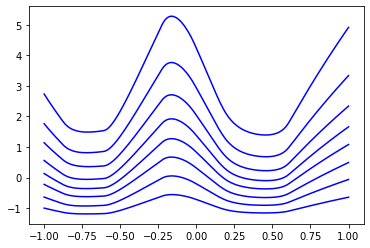

In [93]:
for i in range(int(2*num_hypotheses)):
    train_mhp_model(my_model, optimizer, draw_samples_callcenter_normalized, nearest_l2_loss_nd, 3000, 1000, 0.0)
    if i % 5 == 4:
        plot_hypotheses(my_model, torch.linspace(-1,1, 200))

In [94]:
# Save the L2 model
torch.save(my_model.state_dict(), f"data/callcenter_l2_{num_hypotheses}_hyp.dat")

# Train the model with the log loss

You can either retrain a model from scratch with the log loss (run the above cell which creates the model and the alignment step again) or use the model pretrained with the $l_2$ loss. 

Training with the $l_2$ is more efficient and we recommend using it as a valuable pretraining step.
To show that it is still possible to train it from scratch, we include the next cells, but using the pretrained model is faster, so skip the next cell, if you are not interested.

In [52]:
## Optional to train from scratch (skip if not interested)
my_model = MHPModel1D(neur_hidden=80, num_hypotheses=num_hypotheses)
optimizer = optim.Adam(my_model.parameters(), lr=1e-3)
pre_train_mhp_model(my_model)

for i in range(int(1.3*num_hypotheses)):
    optimizer = optim.Adam(my_model.parameters(), lr=3e-4)
    train_mhp_model(my_model, optimizer, draw_samples_callcenter_normalized, nearest_log_loss_nd_delta, 5000, 1000, 0.01 if i < 5 else 0.0)
    if i % 5 == 4:
        plot_hypotheses(my_model, torch.linspace(-1,1, 200))

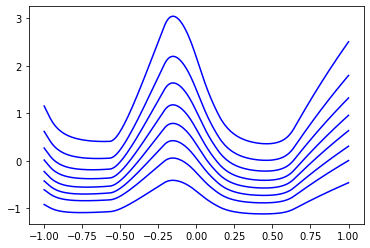

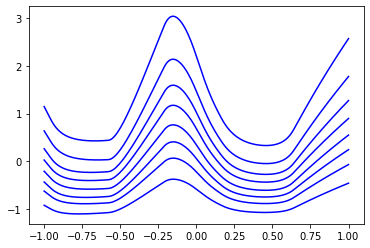

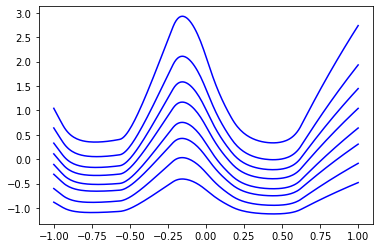

In [95]:
for i in range(int(2*num_hypotheses)):
    optimizer = optim.Adam(my_model.parameters(), lr=1e-4)
    train_mhp_model(my_model, optimizer, draw_samples_callcenter_normalized, nearest_log_loss_nd_delta, 5000, 1000, 0.01 if i < 5 else 0.0)
    if i % 5 == 4:
        plot_hypotheses(my_model, torch.linspace(-1,1, 200))

In [96]:
# Save the Log model
torch.save(my_model.state_dict(), f"data/callcenter_log_{num_hypotheses}_hyp.dat")

In [115]:
# Load a model (optional, if you have not trained one yourself)
num_hypotheses = 40
my_model = MHPModel1D(neur_hidden=80, num_hypotheses=num_hypotheses)
my_model.load_state_dict(torch.load(f"data/callcenter_log_{num_hypotheses}_hyp.dat"))

<All keys matched successfully>

Plot the density overlayed with the hypotheses.

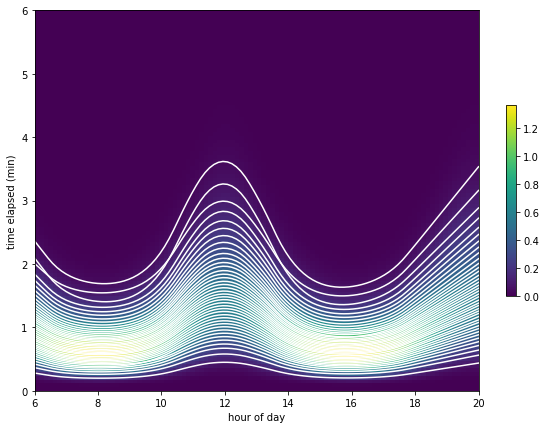

In [116]:
# Overlay plot
y_vals = torch.linspace(6, 20, 100)
x_vals = torch.linspace(0, 6, 100)
colorplot_densities_erlang(x_vals, y_vals, arrival_rate)
plt.xlabel("hour of day")
plt.ylabel("time elapsed (min)")
plt.colorbar(shrink=0.5)

my_model.eval()
condition = torch.linspace(-1, 1, 100)
pts = my_model(condition.reshape(-1, 1))
pts = pts.detach().numpy()
for i in range(0, my_model.num_hypotheses):
    plt.plot(y_vals, pts[:, i]*0.6+1,  '-w')
plt.gcf().set_size_inches(10,7)

Because the distribution is distorted with the L2-loss and is non-symmetric, the expected value $\mathbb{E}[w]$ will differ when the L2-Loss is used. This is shown in the next plot as a funtion of the condition $h$.

Text(0.5, 1.0, 'Expected value distortion')

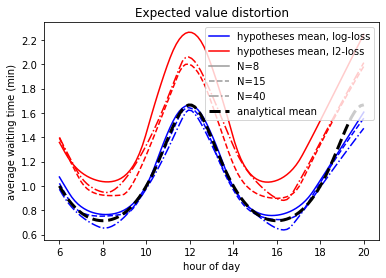

In [111]:
num_hypotheses = [8, 15, 40]
line_sty = ["-", "--", "-."]

for i, n in enumerate(num_hypotheses):
    my_model_log = MHPModel1D(neur_hidden=80, num_hypotheses=n)
    my_model_l2 = MHPModel1D(neur_hidden=80, num_hypotheses=n)
    my_model_log.load_state_dict(torch.load(f"data/callcenter_log_{n}_hyp.dat"))
    my_model_l2.load_state_dict(torch.load(f"data/callcenter_l2_{n}_hyp.dat"))

    condition_norm = torch.linspace(-1, 1, 100)
    condition_denorm = condition_norm*7+13
    if i == 0:
        plt.plot(condition_denorm, model_res1, "b"+line_sty[i], label = "hypotheses mean, log-loss")
        plt.plot(condition_denorm, model_res2, "r"+line_sty[i], label = "hypotheses mean, l2-loss")
    else:
        plt.plot(condition_denorm, model_res1, "b"+line_sty[i])
        plt.plot(condition_denorm, model_res2, "r"+line_sty[i])
    
    model_res1 = my_model_log(condition_norm.reshape(-1,1)).detach().mean(dim=1)*0.6+1
    model_res2 = my_model_l2(condition_norm.reshape(-1,1)).detach().mean(dim=1)*0.6+1
    plt.plot([],[], "0.6", linestyle=line_sty[i], label="N="+str(n))

# plot the analytical mean of erlang distribution
analytical_exp = 5/arrival_rate(condition_denorm)
plt.plot(condition_denorm, analytical_exp, "--k", label = "analytical mean", linewidth=3.0)

plt.legend()
plt.xlabel("hour of day")
plt.ylabel("average waiting time (min)")
plt.title("Expected value distortion")

Text(0.5, 1.0, 'Standard deviation distortion')

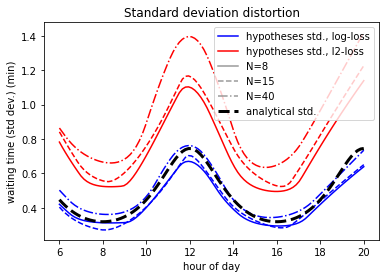

In [112]:
for i, n in enumerate(num_hypotheses):
    my_model_log = MHPModel1D(neur_hidden=80, num_hypotheses=n)
    my_model_l2 = MHPModel1D(neur_hidden=80, num_hypotheses=n)
    my_model_log.load_state_dict(torch.load(f"data/callcenter_log_{n}_hyp.dat"))
    my_model_l2.load_state_dict(torch.load(f"data/callcenter_l2_{n}_hyp.dat"))

    condition_norm = torch.linspace(-1, 1, 100)
    condition_denorm = condition_norm*7+13
    model_res1 = (my_model_log(condition_norm.reshape(-1,1)).detach()*0.6+1).std(dim=1)
    model_res2 = (my_model_l2(condition_norm.reshape(-1,1)).detach()*0.6+1).std(dim=1)
    if i == 0:
        plt.plot(condition_denorm, model_res1, "b"+line_sty[i], label = "hypotheses std., log-loss")
        plt.plot(condition_denorm, model_res2, "r"+line_sty[i], label = "hypotheses std., l2-loss")
    else:
        plt.plot(condition_denorm, model_res1, "b"+line_sty[i])
        plt.plot(condition_denorm, model_res2, "r"+line_sty[i])
    plt.plot([],[], "0.6", linestyle=line_sty[i], label="N="+str(n))
    
analytical_std = np.sqrt(5)/arrival_rate(condition_denorm)
plt.plot(condition_denorm, analytical_std, "--k", label = "analytical std.", linewidth=3.0)
plt.legend()
plt.xlabel("hour of day")
plt.ylabel("waiting time (std dev.) (min)")
plt.title("Standard deviation distortion")

Now create histograms with the shares of each model hypothesis

In [57]:
def get_shares_of_points(x, pnts):
    """ Get the shares of probability mass of each of the n Points
        x: The samples  [batch_size, dim]
        pnts: The values of the hypotheses for a specific sample. Shape [batch_size, n, dim]
        returns n-array with shares, sum(shares)=1.0
    """
    dims = x.shape[1]
    distance_vect = pnts - x.reshape(-1, 1, dims)
    dists2 = torch.sum(distance_vect * distance_vect, dim=2)  # shape [batch_size, n]
    _, ind = torch.min(dists2, dim=1)
    shares = torch.zeros(pnts.shape[1])
    uniques, cnts = torch.unique(ind, sorted=False, return_counts=True)
    shares[uniques] = cnts.float()
    return shares/pnts.shape[0]

AxesSubplot(0.125,0.125;0.352273x0.755)
Shares: tensor([0.0667, 0.0642, 0.0694, 0.0689, 0.0737, 0.0724, 0.0598, 0.0600, 0.0648,
        0.0725, 0.0703, 0.0661, 0.0631, 0.0625, 0.0656])
AxesSubplot(0.547727,0.125;0.352273x0.755)
Shares: tensor([0.0804, 0.0376, 0.0986, 0.1144, 0.1108, 0.1013, 0.0939, 0.0881, 0.0715,
        0.0761, 0.0370, 0.0544, 0.0226, 0.0101, 0.0031])


Text(0.5, 0, 'Hypothesis')

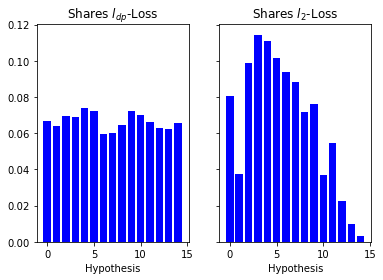

In [58]:
import matplotlib.pyplot as plt
def plot_histogram(myax, model, sample_func):
    """ Plot a histogram with the shares of the data into axis ax for each hypothesis in model of points sampled from sample_func """
    print(myax)
    num_samples_hist = 100000
    cond, samples = sample_func(num_samples_hist, enlarge_range=False)
    hypotheses = model(cond.reshape(-1,1)).detach()
    shares = get_shares_of_points(samples.reshape(-1,1), hypotheses.reshape(-1,model.num_hypotheses,1))
    print("Shares:", shares)
    myax.bar(torch.arange(0,model.num_hypotheses), shares, 0.8, color='b')
    #myax.scatter(torch.arange(0,model.num_hypotheses), shares, color='b') # (There is some bug with bar, try this if it doesnt work.)
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
plot_histogram(ax1, my_model_log, draw_samples_callcenter_normalized)
ax1.set_title(r"Shares $l_{dp}$-Loss")
ax1.set_xlabel("Hypothesis")
plot_histogram(ax2, my_model_l2, draw_samples_callcenter_normalized)
ax2.set_title(r"Shares $l_2$-Loss")
ax2.set_xlabel("Hypothesis")

With the Log-Loss, the shares are approximately equal for each hypotheses, while they differ considerably for the L2-Loss.

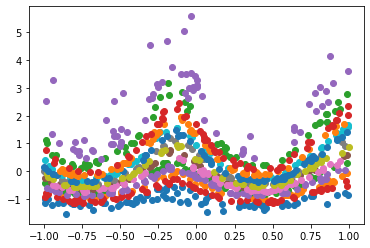

In [49]:
# An additional scatter plot to show how the samples are assigned to the hypotheses.
num_samples_hist = 1000
cond, samples = draw_samples_callcenter_normalized(num_samples_hist, enlarge_range=False)
hypotheses = my_model(cond.reshape(-1,1)).detach()
distance_vect = hypotheses - samples.reshape(-1, 1)
dists2 = distance_vect * distance_vect
_, ind = torch.min(dists2, dim=1)
for i in range(15):
    plt.scatter(cond[ind == i], samples[ind==i], )

### 5.2. Train on the eye diagram example

In [118]:
my_model_eye = MHPModel1D(neur_hidden=80, num_hypotheses=24)

The models for the eye diagram feature 80 hidden units as well, but have 24 outputs, which is a mulitple of 8 (then 3 outputs can be assigned to each mixture component)

In [267]:
optimizer = optim.Adam(my_model_eye.parameters(), lr=1e-3)

In [268]:
pre_train_mhp_model(my_model_eye)

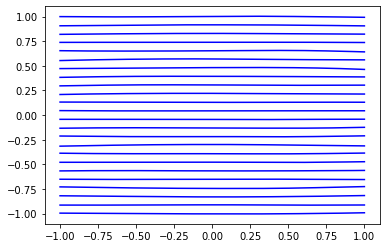

In [269]:
plot_hypotheses(my_model_eye, torch.linspace(-1,1, 200)) 

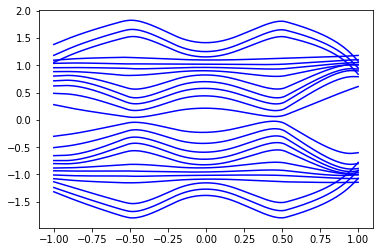

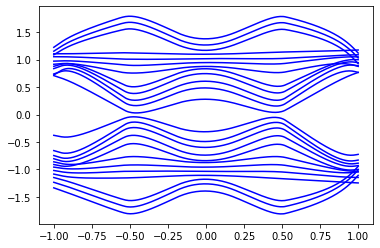

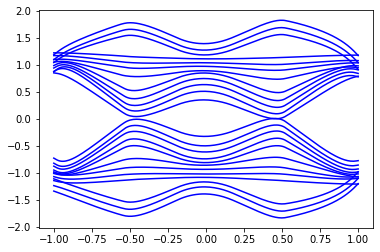

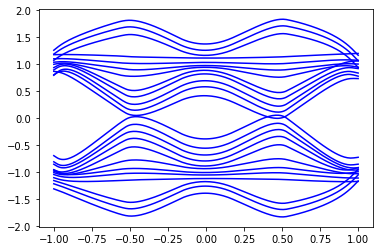

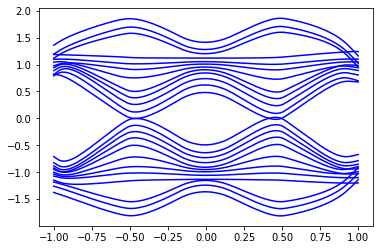

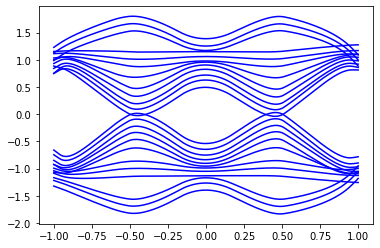

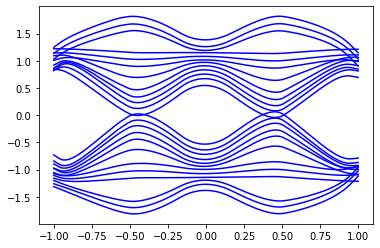

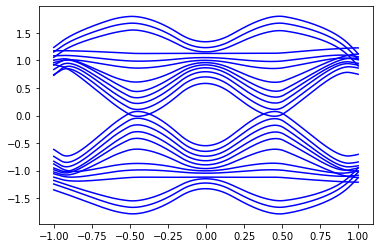

In [111]:
# Run as long until satisfied
for i in range(8):
    optimizer = optim.Adam(my_model_eye.parameters(), lr=1e-3)
    train_mhp_model(my_model_eye, optimizer, draw_samples_eye_diagram, nearest_l2_loss_nd, 3000, 1000, 0.0)
    plot_hypotheses(my_model_eye, torch.linspace(-1,1, 200))

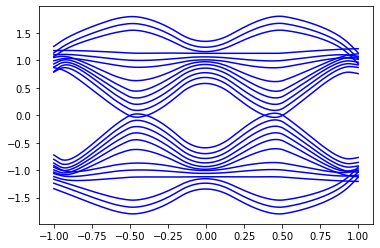

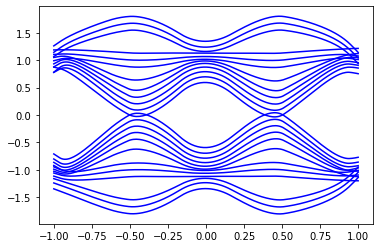

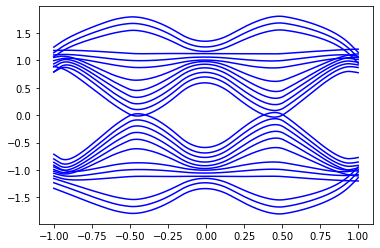

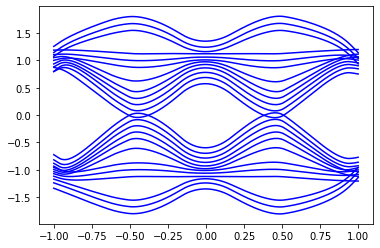

In [112]:
# Finetuning with smaller lr
for i in range(4):
    optimizer = optim.Adam(my_model_eye.parameters(), lr=1e-4)
    train_mhp_model(my_model_eye, optimizer, draw_samples_eye_diagram, nearest_l2_loss_nd, 1000, 3000, 0.0)
    plot_hypotheses(my_model_eye, torch.linspace(-1,1, 200))

In [113]:
# Save the L2 model
torch.save(my_model_eye.state_dict(), "data/eye_l2.dat")

## Conitinue training with the log loss

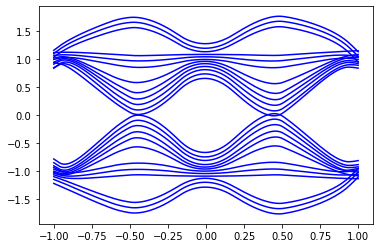

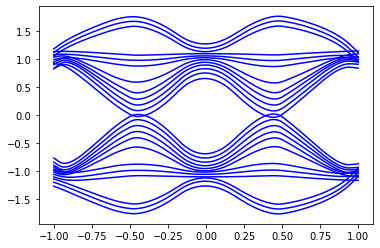

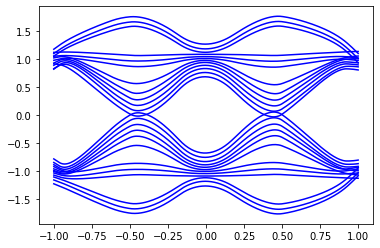

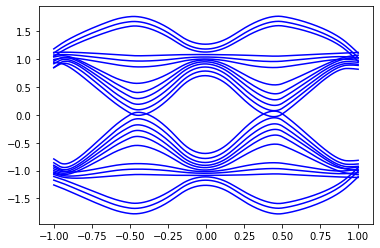

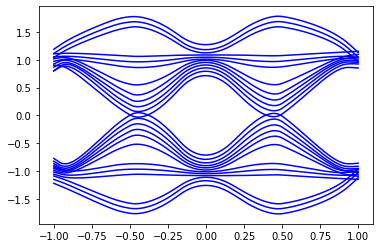

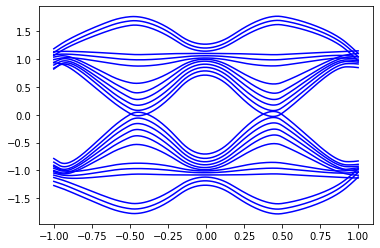

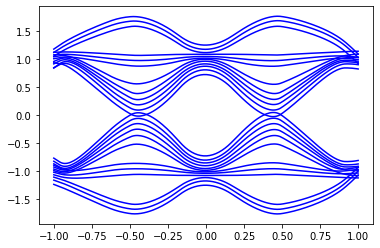

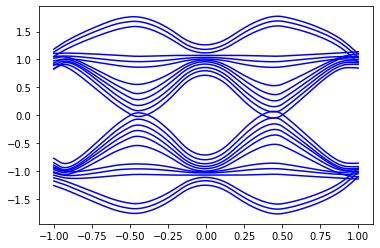

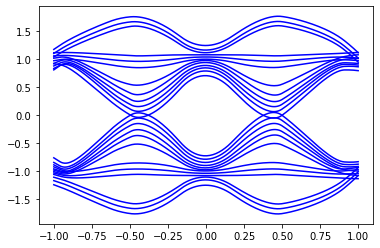

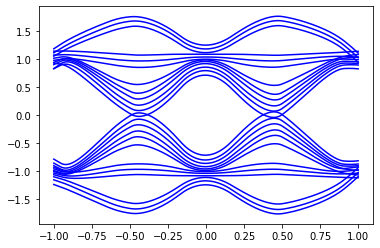

In [116]:
# Run this cell until satisfied with the result
for i in range(10):
    optimizer = optim.Adam(my_model_eye.parameters(), lr=1e-4)
    train_mhp_model(my_model_eye, optimizer, draw_samples_eye_diagram, nearest_log_loss_nd_delta, 3000, 1000, 0.00)
    plot_hypotheses(my_model_eye, torch.linspace(-1,1, 200))

In [120]:
# Save the L2 model 
torch.save(my_model_eye.state_dict(), "data/eye_log.dat")

In [119]:
# Load a model (optional, if you have not trained one yourself)
my_model_eye.load_state_dict(torch.load("data/eye_log.dat"))

<All keys matched successfully>

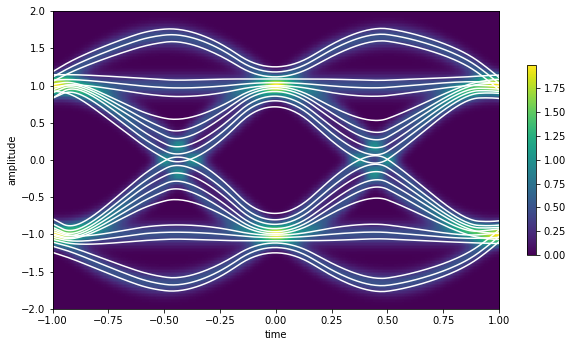

In [120]:
# Overlay plot
y_vals = torch.linspace(-1, 1, 400)
x_vals = torch.linspace(-2, 2, 200)
colorplot_densities(x_vals, y_vals, weights, loc_fun_eye)
plt.xlabel("time")
plt.ylabel("amplitude")
plt.colorbar(shrink=0.5)

my_model_eye.eval()
condition = torch.linspace(-1, 1, 200)
pts = my_model_eye(condition.reshape(-1, 1))
pts = pts.detach().numpy()
for i in range(0, my_model_eye.num_hypotheses):
    plt.plot(condition, pts[:, i],  '-w')
plt.gcf().set_size_inches(10,7)

Plot the shares again.

AxesSubplot(0.125,0.125;0.352273x0.755)
Shares: tensor([0.0406, 0.0393, 0.0404, 0.0441, 0.0417, 0.0428, 0.0402, 0.0417, 0.0420,
        0.0401, 0.0439, 0.0424, 0.0404, 0.0432, 0.0421, 0.0430, 0.0381, 0.0390,
        0.0424, 0.0484, 0.0427, 0.0427, 0.0390, 0.0396])
AxesSubplot(0.547727,0.125;0.352273x0.755)
Shares: tensor([0.0254, 0.0454, 0.0380, 0.0317, 0.0499, 0.0457, 0.0402, 0.0499, 0.0476,
        0.0507, 0.0456, 0.0287, 0.0253, 0.0421, 0.0485, 0.0529, 0.0508, 0.0400,
        0.0489, 0.0504, 0.0318, 0.0373, 0.0481, 0.0251])


Text(0.5, 0, 'Hypothesis')

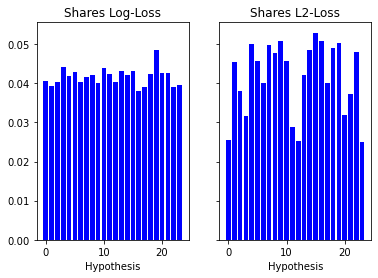

In [121]:
my_model_eye_log = MHPModel1D(neur_hidden=80, num_hypotheses=24)
my_model_eye_l2 = MHPModel1D(neur_hidden=80, num_hypotheses=24)
my_model_eye_log.load_state_dict(torch.load("data/eye_log.dat"))
my_model_eye_l2.load_state_dict(torch.load("data/eye_l2.dat"))

fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
plot_histogram(ax1, my_model_eye_log, draw_samples_eye_diagram)
ax1.set_title("Shares Log-Loss")
ax1.set_xlabel("Hypothesis")
plot_histogram(ax2, my_model_eye_l2, draw_samples_eye_diagram)
ax2.set_title("Shares L2-Loss")
ax2.set_xlabel("Hypothesis")